# **Machine Learning Fairness in Classification**


![Fair](https://drive.google.com/uc?export=download&id=1Ab4dYqz154mnmS76PT_nOzkP7PcQc7AG)




<a href="https://colab.research.google.com/drive/1MhORI8YwR9n5rWrMgYbPIxjJtb-dKrj1?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

© Deep Learning Indaba 2023. Apache License 2.0.

**Authors:** Deborah .D. Kanubala, John Bagiliko

**Introduction:**

The use of machine learning continues to surge across almost every domain. Despite its excellent performance in many tasks, often surpassing human capabilities, it also poses significant potential risks. In many cases, it is observed to discriminate against people based on their sensitive attributes, such as race, gender, age, etc.

The goal is to introduce students to the development of fair machine learning models, with a specific focus on group fairness. We will review two popular group fairness metrics, namely Demographic parity and Equality of opportunity. Our concentration will be on ensuring group fairness by employing the following fairness approaches:

- Pre-Processing Approach using disparate impact (i.e removing the sensitive feature)

- In-Processing Approach using lagragrian fairness approach (regularized on demographic parity and equality of opportunity)

Throughout the tutorial, we will use a synthetic loan approval dataset. In the final section you will be encouraged to apply these concepts to a real dataset.


**Acknowledgement:**
This notebook was taken from / was inspired in parts by code available from the probabilistic learning group [here](https://github.com/probabilistic-learning/LvivSummerSchool19/tree/master/Code) of [Prof.Dr.Isabel Valera](https://ivaleram.github.io/). Special mention particuarly to [Miriam Rateike](https://sites.google.com/view/miriam-rateike/about) and [Adrián Javaloy](https://javaloy.netlify.app/) who originally developed the notebook.



**Topics:** Supervised Learning, Classification, Error metrics


Level: Beginner




**Aims/Learning Objectives:**

- Learn different technqiues to evaluating group fairness.
- Understanding fairness-accuracy tradeoffs.

**Prerequisites:**

Basic Python programming

[Pytorch](https://pytorch.org/tutorials/beginner/basics/intro.html) - Beginner level


**Before you start:**
For this practical, you will need to use a GPU to speed up training. To do this, go to the "Runtime" menu in Colab, select "Change runtime type" and then in the popup menu, choose "GPU" in the "Hardware accelerator" box.



# **Table of Content**


>[Machine Learning Fairness in Classification](#scrollTo=JzQI7L2HGM0S)

>>[Installation and Download](#scrollTo=56cad8e8)

>>[Datasets](#scrollTo=d2e9523f)

>>[What Next?](#scrollTo=49ce7bfa)

>[Fairness Notions](#scrollTo=41391e6c)

>>[Fairness Metrics](#scrollTo=6fbcab70)

>>>[Demographic parity](#scrollTo=ffbbde4d)

>>>[Equal Opportunity](#scrollTo=c01100b2)

>[Plain classifier](#scrollTo=f2dd7dd3)

>[Unaware classifier](#scrollTo=4237e67a)

>[Mechanisms to  achieve group fairness](#scrollTo=5nu1m4ODG6Fr)

>[In-processing](#scrollTo=2d634b15)

>>[Training Framework](#scrollTo=4a3ad2d6)

>>[Plain Classifier](#scrollTo=f5f5afd6)

>>>[Binary Cross-Entropy](#scrollTo=f5f5afd6)

>>>[Fair Classifier - Demographic Parity](#scrollTo=5ca373fe)

>>>[Fair Classifier - Equal Opportunity](#scrollTo=1961184f)

>[Fairness-Accuracy Tradeoff](#scrollTo=2d5d62bd)

>[Take Home](#scrollTo=a00ac414)

>>[Compas Data](#scrollTo=1c056057)

>[Further Reading](#scrollTo=2vgsK-ZPBYh2)

>[Conclusion](#scrollTo=9c8672c2)

>[Feedback](#scrollTo=mBkhQ-XoBjwQ)



In [ ]:
# @title **Paths to follow:** What is your level of experience in the topics presented in this notebook? (Run Cell)
experience = "intermediate" #@param ["beginner", "intermediate", "advanced"]

sections_to_follow=""

if experience == "beginner":
  sections_to_follow="Introduction -> 1.1 Subsection -> 2.1 Subsection -> Conclusion -> Feedback"
elif experience == "intermediate":
  sections_to_follow="Introduction -> 1.2 Subsection -> 2.2 Subsection -> Conclusion -> Feedback"
elif experience == "advanced":
  sections_to_follow="Introduction -> 1.3 Subsection -> 2.3 Subsection -> Conclusion -> Feedback"

print(f"Based on your experience, it is advised you follow these -- {sections_to_follow} sections. Note this is just a guideline.")

Based on your experience, it is advised you follow these -- Introduction -> 1.2 Subsection -> 2.2 Subsection -> Conclusion -> Feedback sections. Note this is just a guideline.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
import math
import random
from scipy.stats import multivariate_normal
import pandas as pd
from sklearn.linear_model import LogisticRegression
warnings.filterwarnings("ignore", category=UserWarning)




## **Installation and Download**

For this notebook, we are using two additional packages. If you have not yet installed them, you can do it e.g. via conda `conda install pytorch torchvision -c pytorch` and `conda install -c conda-forge texttable` or can do it equally using pip e.g `pip3 install torch torchvision`.

In [ ]:
# Uncomment to run
# !pip install texttable

In [ ]:
import torch
import texttable as tt

## **Datasets**

We consider a synthetic dataset with a multivariate normal distribution. It has two nonsensitive attributes and one sensitive attribute. The dataset and its generation function is taken from  Muhammad Bilal Zafar et al. [here](https://github.com/mbilalzafar/fair-classification). Green color denotes the positive class (e.g. creditworthy), blue denotes negative (e.g. not credit worthy). Dots represent the non-protected group (e.g. males) while filled dots represent the protected group (e.g. females).

**Question to think about:**
- What do you observe with respect to the correlation between class labels (green and blue) and the sensitive feature values (protected and non-protected)?  

**Hint:** Think if the dataset is bias based on the distribution between the sensitive groups and the class labels distribution.

In [ ]:
# @title
def generate_synthetic_data(n_samples, plot_data=False):

    """
        From: https://github.com/mbilalzafar/fair-classification
        Code for generating the synthetic data.
        We will have two non-sensitive features and one sensitive feature.
        A sensitive feature value of 0.0 means the example is considered to be in protected group (e.g., female)
        and 1.0 means it's in non-protected group (e.g., male).
    """
    seed = 123
    disc_factor = math.pi / 4.0 # this variable determines the initial discrimination in the data -- decraese it to generate more discrimination

    def gen_gaussian(mean_in, cov_in, class_label):
        nv = multivariate_normal(mean = mean_in, cov = cov_in)
        X = nv.rvs(size=n_samples, random_state=seed) # fix seed
        y = np.ones(n_samples, dtype=float) * class_label
        return nv,X,y

    """ Generate the non-sensitive features randomly """
    # We will generate one gaussian cluster for each class
    mu1, sigma1 = [2, 2], [[5, 1], [1, 5]]
    mu2, sigma2 = [-2,-2], [[10, 1], [1, 3]]
    nv1, X1, y1 = gen_gaussian(mu1, sigma1, 1) # positive class
    nv2, X2, y2 = gen_gaussian(mu2, sigma2, -1) # negative class

    # join the positive and negative class clusters
    X = np.vstack((X1, X2))
    y = np.hstack((y1, y2))

    # shuffle the data
    perm = list(range(0,n_samples*2))

    random.seed(seed)
    random.shuffle(perm)

    X = X[perm]
    y = y[perm]

    rotation_mult = np.array([[math.cos(disc_factor), -math.sin(disc_factor)], [math.sin(disc_factor), math.cos(disc_factor)]])
    X_aux = np.dot(X, rotation_mult)


    """ Generate the sensitive feature here """
    x_control = [] # this array holds the sensitive feature value
    for i in range (0, len(X)):
        x = X_aux[i]

        # probability for each cluster that the point belongs to it
        p1 = nv1.pdf(x)
        p2 = nv2.pdf(x)

        # normalize the probabilities from 0 to 1
        s = p1+p2
        p1 = p1/s
        p2 = p2/s

        r = random.uniform(0.0, 1.0) # generate a random number from 0 to 1

        if r < p1: # the first cluster is the positive class
            x_control.append(1.0) # 1.0 means its male
        else:
            x_control.append(0.0) # 0.0 -> female

    x_control = np.array(x_control)


    #x_control = {"s1": x_control} # all the sensitive features are stored in a dictionary
    X = np.concatenate((X,x_control.reshape(-1,1)), axis=1)
    data = np.concatenate((X,y.reshape(-1,1)),axis = 1)
    return pd.DataFrame(data=data, columns = ["x1","x2","sensitive","y"]), X, y

def plot_data(X,y,X_sens,ax=None, name=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(10,10))
    num_to_draw = 200 # we will only draw a small number of points to avoid clutter
    x_draw = X[:num_to_draw]
    y_draw = y[:num_to_draw]
    x_control_draw = X_sens[:num_to_draw]
    X_s_0 = x_draw[x_control_draw == 0.0]
    X_s_1 = x_draw[x_control_draw == 1.0]
    y_s_0 = y_draw[x_control_draw == 0.0]
    y_s_1 = y_draw[x_control_draw == 1.0]
    ax.scatter(X_s_0[y_s_0==1.0][:, 0], X_s_0[y_s_0==1.0][:, 1], color='green', marker='.', s=100, facecolors='none',linewidth=1.5, label= "Prot. Positive")
    ax.scatter(X_s_0[y_s_0==-1.0][:, 0], X_s_0[y_s_0==-1.0][:, 1], color='blue', marker='.', s=100, facecolors='none',linewidth=1.5, label = "Prot. Negative")
    ax.scatter(X_s_1[y_s_1==1.0][:, 0], X_s_1[y_s_1==1.0][:, 1], color='green', marker='o', s=100,  label = "Non-prot. Positive")
    ax.scatter(X_s_1[y_s_1==-1.0][:, 0], X_s_1[y_s_1==-1.0][:, 1], color='blue', marker='o', s=100, label = "Non-prot. Negative")


    ax.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off') # dont need the ticks to see the data distribution
    ax.tick_params(axis='y', which='both', left='off', right='off', labelleft='off')
    plt.legend(fontsize=15, bbox_to_anchor=(1.05, 1), loc='upper left')
#     plt.legend(handles=[p1, p2], title='title', bbox_to_anchor=(1.05, 1), loc='upper left', prop=fontP)
#     ax.title.set_text('{} dataset'.format(name), fontsize=20)
    if name is not None:
        fig.suptitle('{} dataset'.format(name), fontsize=20)
    plt.xlabel("score X1", fontsize=20)
    plt.ylabel("score X2", fontsize=20)
    plt.xlim((-12,10))
    plt.ylim((-7,8))
    plt.show()


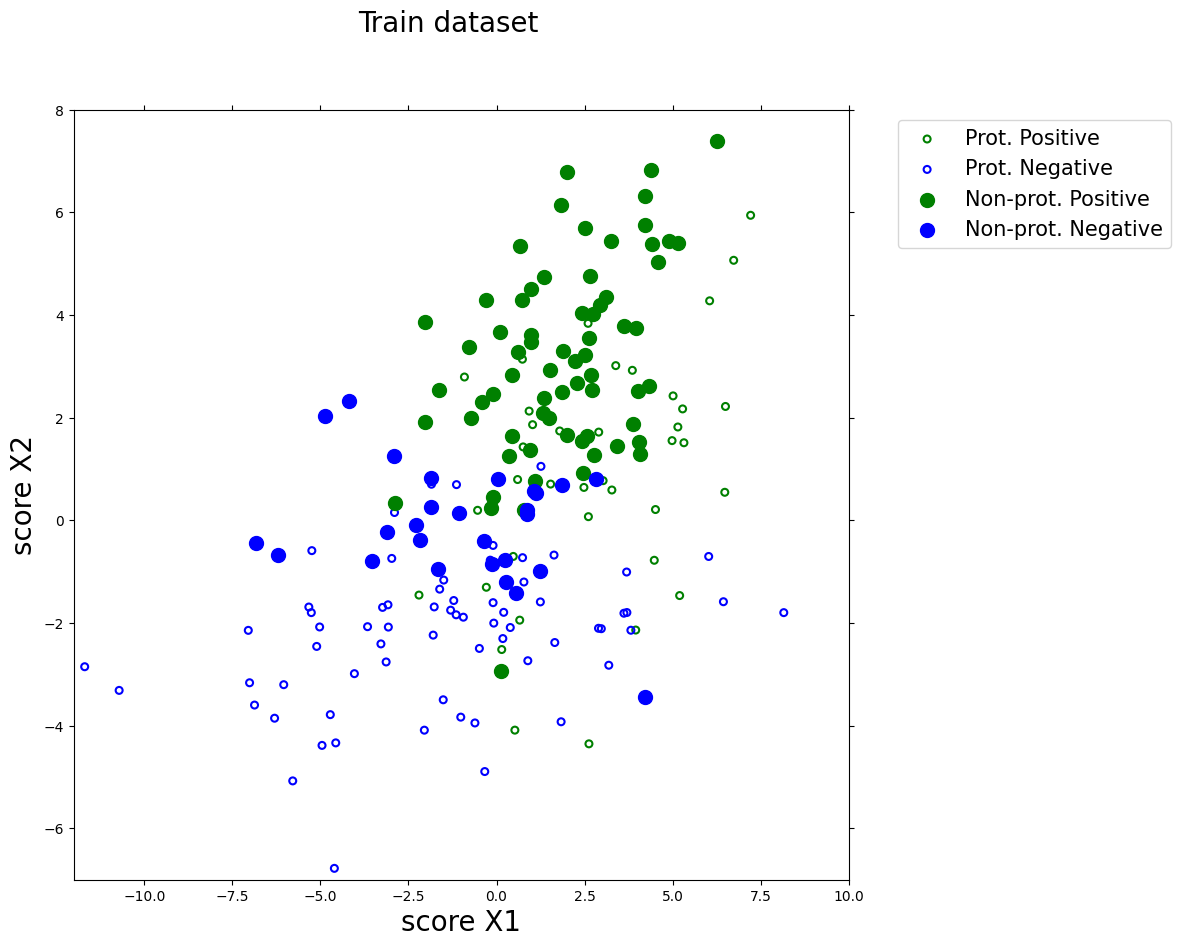

In [ ]:
# @title
# Plotting training and test data
train_data, X_train, y_train = generate_synthetic_data(2000, True) # 500 training samples
plot_data(X_train[:,0:2], y_train, X_train[:,2], name='Train')
test_data, X_test, y_test= generate_synthetic_data(500, True) # 500 test samples
# plot_data(X_test[:,0:2], y_test, X_test[:,2], name='test')


**Observation** It can be seen that class labels (green and blue) are highly correlated with the sensitive feature value (protected and non-protected), that is, most of the green (positive class) points are in the non-protected class while most of blue (negative class) points are in the protected class.

## **What Next?**

Throughout this notebook we will be analyzing with different fairness metrics by computing the test error of the classifier(s), computing different fairness metrics, outputting the confusion matrix and plotting the classification boundary. Lets start with looking at the functions that perfom this:


**Test error**

In [ ]:
def test_error(y_pred,y_true):
    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.numpy()
        y_true = y_true.numpy()
    return np.mean(y_pred!=y_true)

# **Fairness Notions**  <a class="anchor" id="metric"></a>






![Fairness Notions](https://drive.google.com/uc?export=download&id=1OvKjpw-WDbN3dHwwANtgtAX-euOQcUj_)


## **Fairness Metrics**

We will now take a look at some common group fairness metrics: *demographic parity* and *equality of opportunity*, which is a weaker version of *equalized odds*. Note, for simplicity, we assume throughout binary targets $Y$, $\hat{Y}$ and protected attributes $Z$.


### **Demographic parity**

*Demographic parity* ([Dwork et al. (2011)](https://dl.acm.org/doi/pdf/10.1145/2090236.2090255)): A binary predictor $\hat{Y}$ satisfies demographic parity  with respect to $Z$ if $$\operatorname{Pr}\{\widehat{Y}=1 \mid Z=0\}=\operatorname{Pr}\{\widehat{Y}=1 \mid Z=1\}.$$


In [ ]:
def demographic_parity(y_pred, mask):
    # mask allows to select members of one group (1 if from group, 0 if not)
    if isinstance(mask, np.ndarray):
        mask = torch.tensor(mask)
    y_cond = y_pred * mask.float()  # conditioned elements
    return y_cond.sum() / mask.sum() # accepted people of group z / total people in group z

### **Equality of Opportunity** ([Hardt et al. (2016)](https://arxiv.org/pdf/1610.02413.pdf))

A binary predictor $\hat{Y}$ satisfies equal opportunity with respect to $Z$ and $Y$ if $$\operatorname{Pr}\{\widehat{Y}=1 \mid Z=0, Y=1\}=\operatorname{Pr}\{\widehat{Y}=1 \mid Z=1, Y=1\}.$$


In [ ]:
def equal_opportunity(y_pred, y, mask):
    # mask allows to select members of one group (1 if from group, 0 if not)
    if isinstance(mask, np.ndarray):
        mask = torch.tensor(mask)
    y_cond = y * y_pred * mask.float()  # conditioned true positives
    return y_cond.sum() / (y * mask.float()).sum() # accepted people of group z that have y=1 / total people in group z that have y=1

In [ ]:
# @title
def confusion_matrix(y_pred, y_true, mask=None):
    y_pred = torch.tensor(y_pred)
    y_true = torch.tensor(y_true)
    size = y_true.size(0) if mask is None else mask.sum().item()
    sum_and_int = lambda x: x.sum().long().item()
    to_percentage = lambda l: [f'{float(y)* 100. / size :.2f}%' for y in l]

    y_pred_binary = (y_pred > 0.5).float()
    if mask is None:
        mask = torch.ones_like(y_pred)

    if isinstance(mask, np.ndarray):
        mask = torch.tensor(mask)
    mask = mask.float()

    true_positives = sum_and_int(y_true * y_pred_binary * mask)
    false_positives = sum_and_int((1 - y_true) * y_pred_binary * mask)

    true_negatives = sum_and_int((1 - y_true) * (1 - y_pred_binary) * mask)
    false_negatives = sum_and_int(y_true * (1 - y_pred_binary) * mask)


    total = true_positives + false_positives + true_negatives + false_negatives

    # Show the confusion matrix
    table = tt.Texttable()
    table.header(['Real/Pred', 'Positive', 'Negative', ''])
    table.add_row(['Positive'] + to_percentage([true_positives, false_negatives, true_positives + false_negatives]))
    table.add_row(['Negative'] + to_percentage([false_positives, true_negatives, false_positives + true_negatives]))
    table.add_row([''] + to_percentage([true_positives + false_positives, false_negatives + true_negatives, total]))

    return table

In [ ]:
# @title
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:            #If no figure handle is provided, it opens the current figure
        ax = plt.gca()

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)    #30 points in the grid axis
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)                 # We create a grid with the x,y coordinates defined above

    # From the grid to a list of (x,y) values.
    # Check Numpy help for ravel()

    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)

    # plot decision boundary and margins
    # In levels we provide a list of floating point numbers indicating
    #the level curves to draw, in increasing order; e.g., to draw just the zero contour pass
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, marker='*', color="orange")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

In [ ]:
# @title
tensor = lambda x: torch.tensor(x.to_numpy())
def get_statistics(model, X_test, y_test, pred, mask, confusion=True):
    print("Test error: ", test_error(pred,y_test))
    if confusion == True:
        print("Confusion matrix all: ")
        print(confusion_matrix(pred,y_test).draw())
        print("Confusion matrix unprotected: ")
        print(confusion_matrix(pred,y_test,mask).draw())
        print("Confusion matrix protected: ")
        print(confusion_matrix(pred,y_test,1-mask).draw())
    pred = torch.tensor(pred)
    y_test = torch.tensor(y_test)
    print("Positive Rate for unprotected: %.3f, for Positive Rate for protected: %.3f, demographic disparity difference: %.3f" % (demographic_parity(pred, mask),demographic_parity(pred,1-mask), np.abs(demographic_parity(pred,mask)-demographic_parity(pred,1-mask))))
    print("Equal opportunity for unprotected: %.3f, Equal opportunity for protected: %.3f, difference: %.3f" % (equal_opportunity(pred, y_test,mask),equal_opportunity(pred, y_test,1-mask), np.abs(equal_opportunity(pred, y_test,mask) - equal_opportunity(pred, y_test,1-mask))))

## **Plain classifier**

We will begin by looking at how a Logistic Regression (LR) classifier separates the given biased dataset.

- Train a LR classifier on the full dataset. You can use a standard implementation from [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), respectively. Evaluate test error, fairness metrics and the confusion matrix for:

i) all samples

ii) only samples of unprotected group

iii) only samples of protected group.

iv) Plot the decision boundary.

Discuss what you observe?

In [ ]:
# @title
# return decision boundary for LR
def get_lr_boundary(coef, intercept, x1, x2):
    w1, w2 = coef
    y1 = -(w1/w2)*x1 - intercept/w2
    y2 = -(w1/w2)*x2 - intercept/w2
    return [[x1,x2],[y1,y2]]


In [ ]:
# select plain dataset training and test
_X_train = train_data[["x1","x2","sensitive"]].to_numpy()
_y_train = train_data["y"].to_numpy()
_X_test = test_data[["x1","x2","sensitive"]].to_numpy()
_y_test = test_data["y"].to_numpy()
s_test = test_data["sensitive"].to_numpy()

In [ ]:
# define and train Logistic Regression classifier
lr_plain = LogisticRegression()
lr_plain.fit(_X_train,_y_train)

# get predictions
y_pred = lr_plain.predict(_X_test)

# get statistics
get_statistics(lr_plain, _X_test, (_y_test+1)/2, (y_pred+1)/2, s_test)

Test error:  0.126
Confusion matrix all: 
+-----------+----------+----------+---------+
| Real/Pred | Positive | Negative |         |
+===========+==========+==========+=========+
| Positive  | 43.20%   | 6.80%    | 50.00%  |
+-----------+----------+----------+---------+
| Negative  | 5.80%    | 44.20%   | 50.00%  |
+-----------+----------+----------+---------+
|           | 49.00%   | 51.00%   | 100.00% |
+-----------+----------+----------+---------+
Confusion matrix unprotected: 
+-----------+----------+----------+---------+
| Real/Pred | Positive | Negative |         |
+===========+==========+==========+=========+
| Positive  | 69.57%   | 4.35%    | 73.91%  |
+-----------+----------+----------+---------+
| Negative  | 7.32%    | 18.76%   | 26.09%  |
+-----------+----------+----------+---------+
|           | 76.89%   | 23.11%   | 100.00% |
+-----------+----------+----------+---------+
Confusion matrix protected: 
+-----------+----------+----------+---------+
| Real/Pred | Positive |

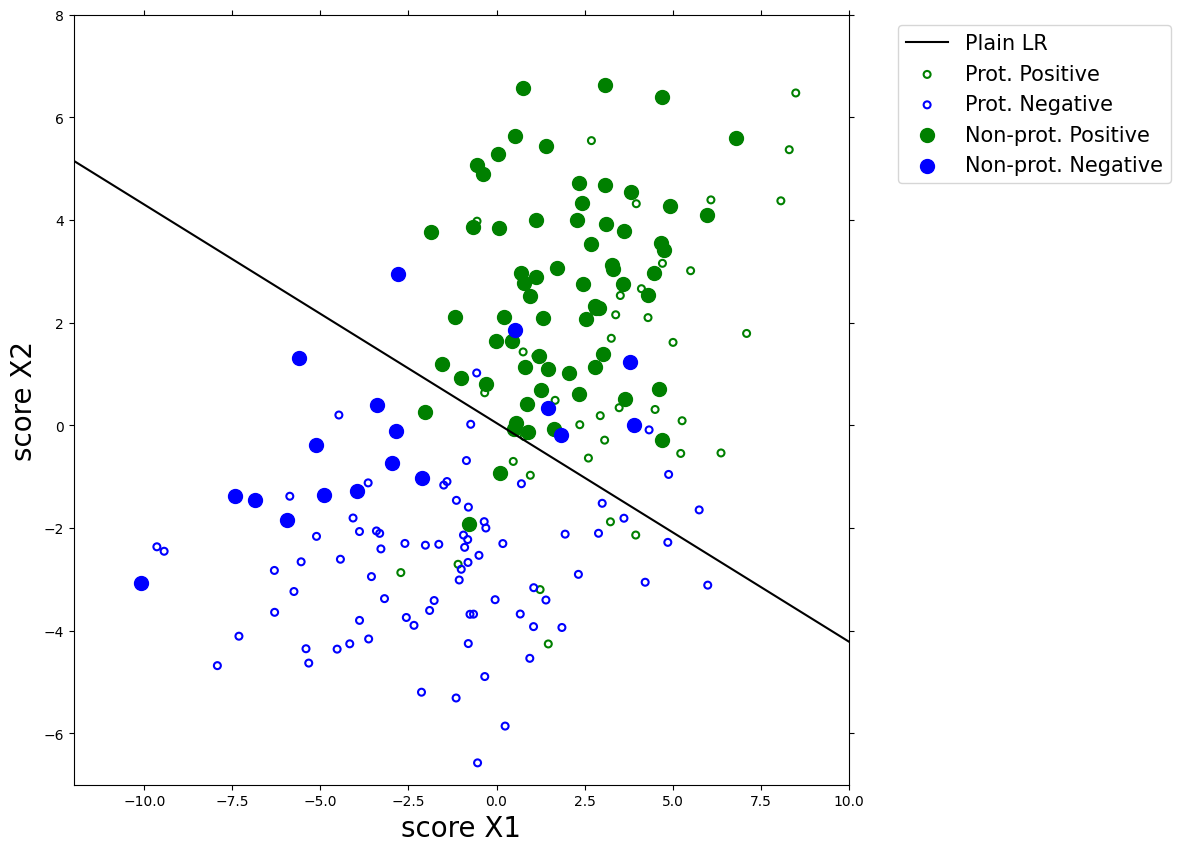

In [ ]:
# @title
# plot data and decision boundary
fig,ax = plt.subplots(1,1, figsize=(10,10))
ax.plot(*get_lr_boundary(lr_plain.coef_[0][0:2], lr_plain.intercept_, -15,10), color="black", label= "Plain LR")
plot_data(X_test[:,0:2], y_test, s_test, ax=ax)

## **Unaware classifier**
Can't we just train a fair classifier by removing the sensitive attribute from our dataset?
- Modify the dataset such that contains only non-sensitive features. Train an LR classifier on it.  Evaluate test error, fairness metrics and the confusion matrix for:

i) all samples

ii) only samples of unprotected group

iii) only samples of protected group

iv) Plot the decision boundary. What do you observe?

In [ ]:
# select plain dataset training and test
_X_train = train_data[["x1","x2"]].to_numpy()
_y_train = train_data["y"].to_numpy()
_X_test = test_data[["x1","x2"]].to_numpy()
_y_test = test_data["y"].to_numpy()
s_test = test_data["sensitive"].to_numpy()

In [ ]:
# define and train Logistic Regression classifier
lr_una = LogisticRegression()
lr_una.fit(_X_train,_y_train)

# get predictions
y_pred = lr_una.predict(_X_test)

# get statistics
get_statistics(lr_una, _X_test, (_y_test+1)/2, (y_pred+1)/2, s_test)

Test error:  0.125
Confusion matrix all: 
+-----------+----------+----------+---------+
| Real/Pred | Positive | Negative |         |
+===========+==========+==========+=========+
| Positive  | 43.30%   | 6.70%    | 50.00%  |
+-----------+----------+----------+---------+
| Negative  | 5.80%    | 44.20%   | 50.00%  |
+-----------+----------+----------+---------+
|           | 49.10%   | 50.90%   | 100.00% |
+-----------+----------+----------+---------+
Confusion matrix unprotected: 
+-----------+----------+----------+---------+
| Real/Pred | Positive | Negative |         |
+===========+==========+==========+=========+
| Positive  | 69.57%   | 4.35%    | 73.91%  |
+-----------+----------+----------+---------+
| Negative  | 7.09%    | 18.99%   | 26.09%  |
+-----------+----------+----------+---------+
|           | 76.66%   | 23.34%   | 100.00% |
+-----------+----------+----------+---------+
Confusion matrix protected: 
+-----------+----------+----------+---------+
| Real/Pred | Positive |

**Observation:**

We observe that the fairness metrics only changed a tiny bit -  this is highly dependent on the dataset.

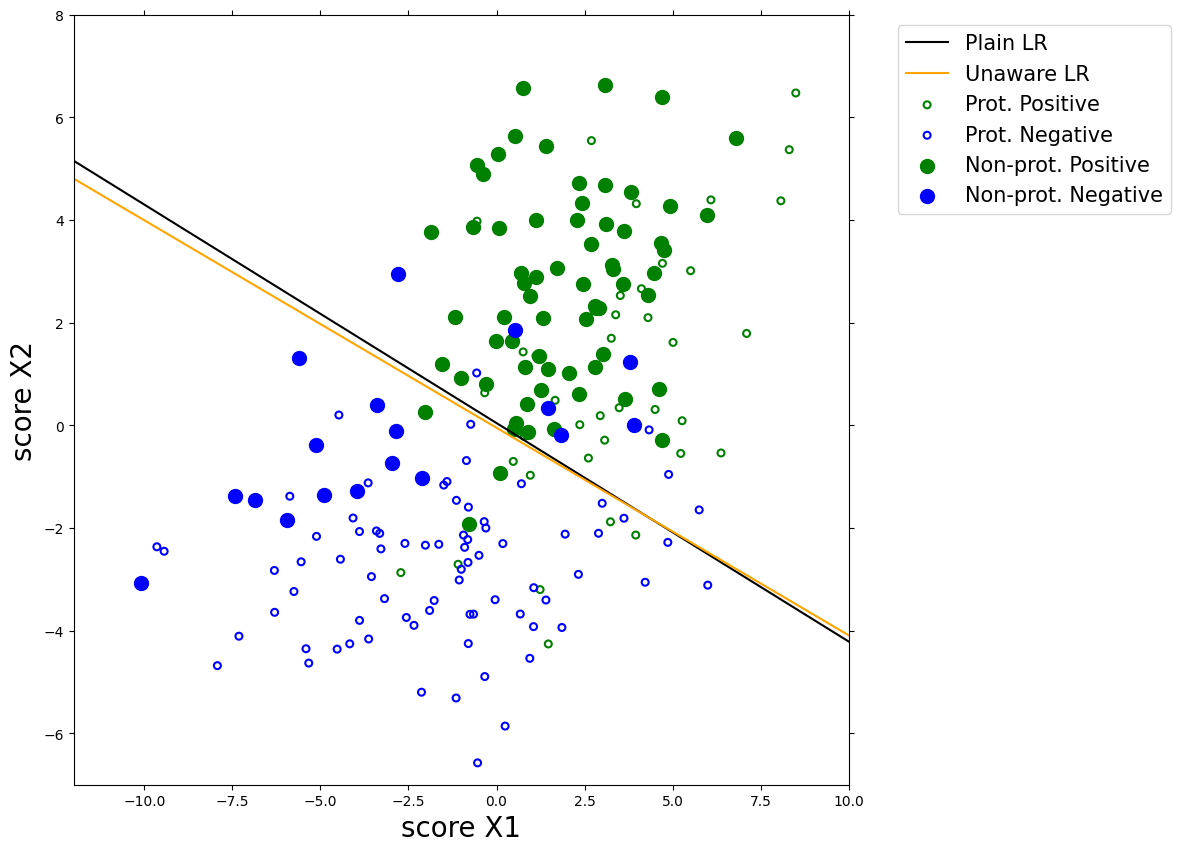

In [ ]:
# @title
fig,ax = plt.subplots(1,1, figsize=(10,10))
ax.plot(*get_lr_boundary(lr_plain.coef_[0][0:2], lr_plain.intercept_, -15,10), color="black", label= "Plain LR")
ax.plot(*get_lr_boundary(lr_una.coef_[0][0:2], lr_una.intercept_, -15,10), color="orange", label= "Unaware LR")
# ax.plot(*get_lr_boundary(lr_una.coef_[0], lr_una.intercept_, -15,10), color="red", label= "Unaware LR")
plot_data(X_test[:,0:2],y_test,s_test,ax=ax)

## Mechanisms to  achieve group fairness

In the ML fairness literature, there are three main approaches to achieveing group fairness:

- pre-preprocessing, which modifies the input data to remove (potential) bias.

- post-processing, which modifies the decisions of a (potentially) unfair classifier.

- in-processing, which modifies training to directly learn a fair classifier

![Method](https://drive.google.com/uc?export=download&id=10TgzfVg9Tal-UwzcEDINnao4JoH4x5Zy)







Lets now take a closer look at one way of altering the training of a classification algorithm to achieve higher levels of fairness (in-processing).

## **In-processing**

Let's now take a more detailed look at in-processing approaches for logistic regression e.g. [Zafar et al. (2017)](https://arxiv.org/pdf/1507.05259.pdf). We provide you with the training framework.

## **Training Framework**

This is the [PyTorch](https://pytorch.org/docs/stable/index.html) training framework for a Logistic Regression (LR) classifier. In order to modify the optimization of the LR classifier we make all function explicit.

In [ ]:
import torch.nn as nn
class LogisticRegression(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.theta = nn.Parameter(torch.randn(size, 1))
        self.bias = nn.Parameter(torch.randn(1))

    def forward(self, x):
        return torch.sigmoid(torch.matmul(x, self.theta)+self.bias).flatten()

    def predict(self, x):
        return self.forward(x) >= 0.5

@torch.no_grad()  # This is to let Pytorch modify our parameters
def gradient_descent(model, learning_rate):
    model.theta -= learning_rate * model.theta.grad
    model.bias -= learning_rate * model.bias.grad

def train(model, loss_function, x, y, epochs, learning_rate, print_freq=500, verbose=True, **kwargs):
    for i in range(epochs):
        model.zero_grad()  # sets all the gradients back to 0

        y_pred = model(x)
        loss = loss_function(y_pred, y, **kwargs)
        if (i == 0 or (i+1) % print_freq == 0)  and verbose:
            print(f'Epoch {i+1}: loss {loss.item()}')

        loss.backward()  # calculates the gradient of all the parameters
        gradient_descent(model, learning_rate)

In [ ]:
# @title
# get training and test datasets as pytorch tensors
X_train_tensor = torch.tensor(X_train).float()
y_train_tensor = (torch.tensor(y_train).float()+1)/2
X_test_tensor = torch.tensor(X_test).float()
y_test_tensor = (torch.tensor(y_test).float()+1)/2
s_train=X_train_tensor[:,2]
s_test = test_data["sensitive"].to_numpy()

## **Plain Classifier**

**Binary Cross-Entropy:**

Logistic regression typically optimizes the log loss, which is the same as optimizing the (binary) cross-entropy. PyTorch provides a ready-to-use function that measures the [Binary Cross Entropy](https://pytorch.org/docs/stable/generated/torch.nn.functional.binary_cross_entropy.html) (BCE) between the target and the output with $N$ samples:
$$BCE = -\frac{1}{N} \sum_{n=1}^{N}\left[y_{n} \log \hat{y}_{n}+\left(1-y_{n}\right) \log \left(1-\hat{y}_{n}\right)\right]$$

- Lets begin with training a plain LR classifier using the framework.

- Use binary cross entropy as loss function, which you hand to the training function.

- Evaluate test error, fairness metrics and the confusion matrix for

i) all samples

ii) only samples of unprotected group and

iii) only samples of protected group.

iv) Plot the decision boundary.

In [ ]:
# define the model
my_model_plain = LogisticRegression(X_train_tensor.size(1))
print(my_model_plain)

LogisticRegression()


In [ ]:

# define the loss function
my_loss_function = nn.functional.binary_cross_entropy  # cross entropy loss
print(my_loss_function)

<function binary_cross_entropy at 0x7cdc2be8beb0>


In [ ]:

# train the model
train(my_model_plain, my_loss_function, X_train_tensor, y_train_tensor, epochs=2000, learning_rate=0.05)

Epoch 1: loss 1.1905022859573364
Epoch 500: loss 0.28546467423439026
Epoch 1000: loss 0.28367358446121216
Epoch 1500: loss 0.2826925218105316
Epoch 2000: loss 0.2821294367313385


In [ ]:
# get model predictions
y_pred_plain =  my_model_plain.predict(X_test_tensor)
# get statistics
get_statistics(my_model_plain, X_test_tensor, y_test_tensor, y_pred_plain, s_test, confusion=False)

Test error:  0.131
Positive Rate for unprotected: 0.762, for Positive Rate for protected: 0.284, demographic disparity difference: 0.478
Equal opportunity for unprotected: 0.935, Equal opportunity for protected: 0.729, difference: 0.206


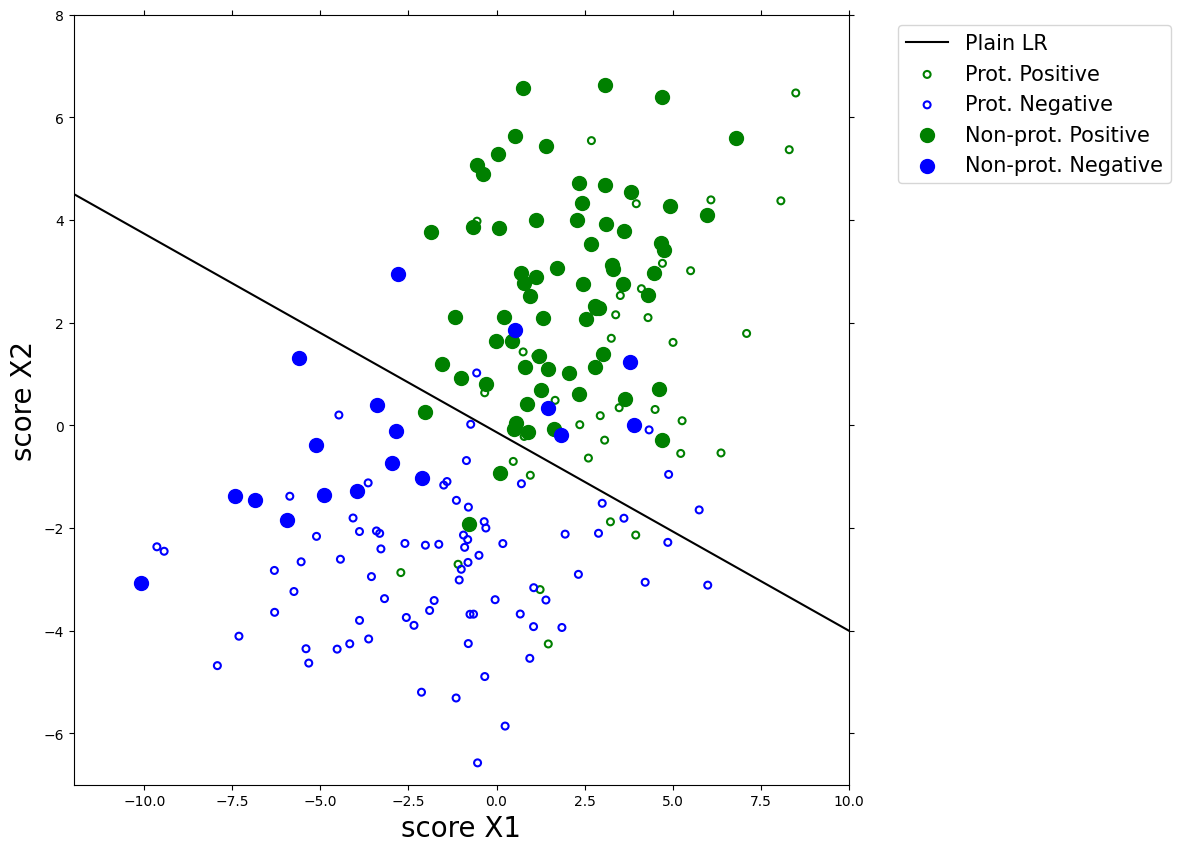

In [ ]:
# @title
# plot decision boundary
fig,ax = plt.subplots(1,1, figsize=(10,10))
ax.plot(*get_lr_boundary(my_model_plain.theta.detach().numpy()[0:2], my_model_plain.bias.detach().numpy()[0], -15,10), color="black", label= "Plain LR")
plot_data(X_test[:,0:2],y_test,X_test[:,2],ax=ax)

### **Fair Classifier - Demographic Parity**

We can formulate the Demographic Parity (DP) fairness constraints in a Lagrange with multiplier $\lambda$:  
$$DP_{Loss} = BCE + \lambda * (\mathbb{E}[\widehat{Y}=1 \mid Z=1] - \mathbb{E}[\widehat{Y}=1 \mid Z=0])^2$$

- Train the LR classifier with the fairness metric `demographic_parity`.  This is a constrained optimization problem and you can use a lagrange approach , i.e. `bce_loss + lambda * (unfairness)^2`. Alter the loss function in a suitable way. Then train and evaluate. You can use $\lambda = 100$. What do you observe?



In [ ]:
# define demographic parity loss
def dp_loss(y_pred, y, X_sens, lambda_ = 100.0):
    bce_loss = nn.functional.binary_cross_entropy(y_pred, y) # binary cross entropy
    dp_unprotected = demographic_parity(y_pred, X_sens)
    dp_protected = demographic_parity(y_pred, 1-X_sens)
    return bce_loss + lambda_ * (dp_unprotected - dp_protected)**2

In [ ]:
# define model
my_model_dp = LogisticRegression(X_train_tensor.size(1))
# define loss function
my_loss_function = dp_loss
# train model
train(my_model_dp, my_loss_function, X_train_tensor, y_train_tensor, X_sens=s_train, epochs=2000, learning_rate=0.05)

Epoch 1: loss 14.00538158416748
Epoch 500: loss 0.6347130537033081
Epoch 1000: loss 0.5755742192268372
Epoch 1500: loss 0.536683976650238
Epoch 2000: loss 0.5164099335670471


In [ ]:
# get predictions
y_pred_dp  = my_model_dp.predict(X_test_tensor)
# get statistivs
get_statistics(my_model_dp, X_test_tensor, y_test_tensor,y_pred_dp ,s_test, confusion=False)

Test error:  0.199
Positive Rate for unprotected: 0.565, for Positive Rate for protected: 0.440, demographic disparity difference: 0.125
Equal opportunity for unprotected: 0.740, Equal opportunity for protected: 0.898, difference: 0.158


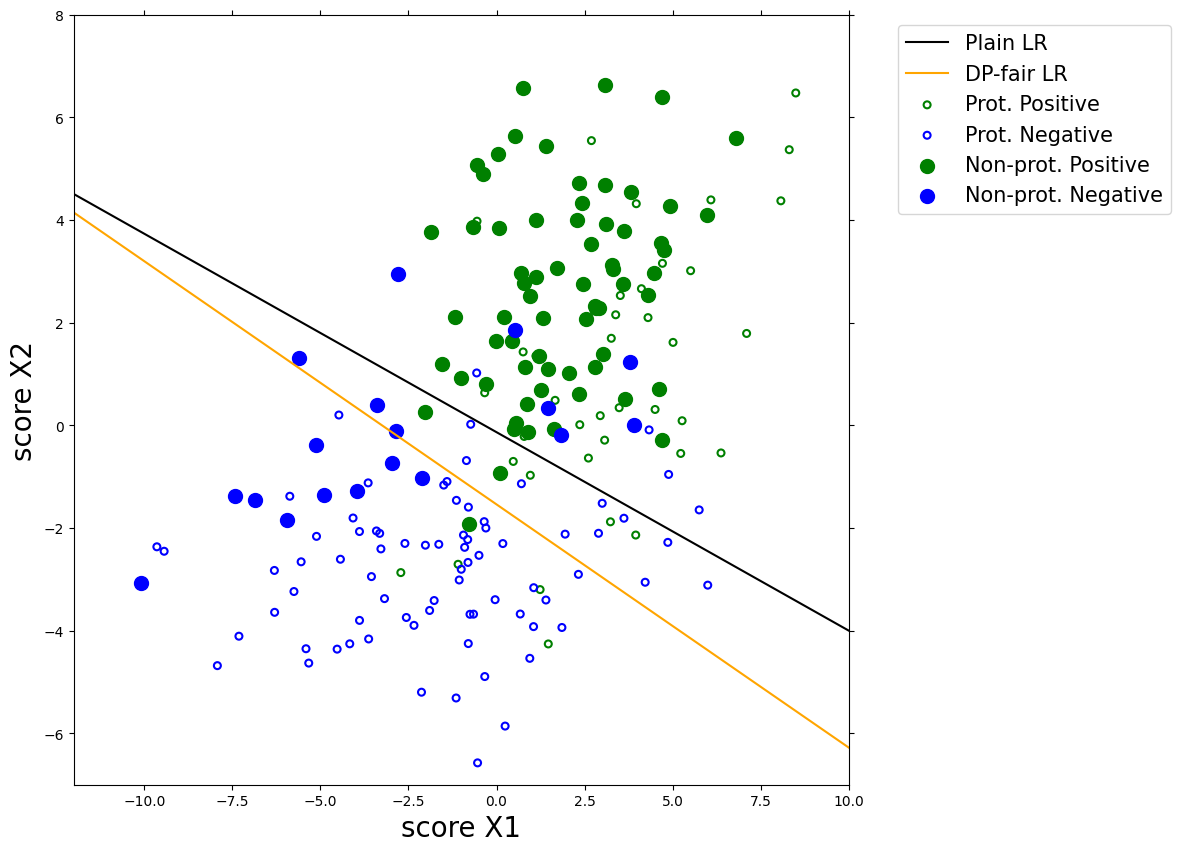

In [ ]:
# @title
# plot
fig,ax = plt.subplots(1,1, figsize=(10,10))
ax.plot(*get_lr_boundary(my_model_plain.theta.detach().numpy()[0:2], my_model_plain.bias.detach().numpy()[0], -15,10), color="black", label= "Plain LR")
ax.plot(*get_lr_boundary(my_model_dp.theta.detach().numpy()[0:2], my_model_dp.bias.detach().numpy()[0], -15,10), color="orange", label= "DP-fair LR")
plot_data(X_test[:,0:2],y_test,X_test[:,2],ax=ax)

### **Fair Classifier - Equal Opportunity**

We can formulate the equal opportunity (EO) fairness constraints in a Lagrange with multiplier $\lambda$:  
$$EO_{Loss} = BCE + \lambda * (\mathbb{E}[\widehat{Y}=1 \mid Z=1, Y=1] - \mathbb{E}[\widehat{Y}=1 \mid Z=0, Y=1])^2$$

- Train the LR classifier with the fairness metric `equal_opportunity`. This is a constrained optimization problem and you can use an lagrange approach , i.e. `bce_loss + lambda * unfairness`. Alter the loss function in a suitable way. Then train and evaluate. You can use $\lambda = 100$. What do you observe?

In [ ]:
# define equal opportunity loss
def eo_loss(y_pred, y, X_sens, lambda_ = 100):
    bce_loss = nn.functional.binary_cross_entropy(y_pred, y)
    eo_unprotected = equal_opportunity(y_pred, y, X_sens)
    eo_protected = equal_opportunity(y_pred,y, 1-X_sens)
    return bce_loss + lambda_ * (eo_unprotected - eo_protected)**2

In [ ]:
# define model
my_model_eo = LogisticRegression(X_train_tensor.size(1))
# define loss function
my_loss_function = eo_loss
# train model
train(my_model_eo, my_loss_function, X_train_tensor, y_train_tensor,  X_sens=s_train, epochs=2000, learning_rate=0.05)

Epoch 1: loss 26.922578811645508
Epoch 500: loss 0.3375798761844635
Epoch 1000: loss 0.3226442039012909
Epoch 1500: loss 0.31920483708381653
Epoch 2000: loss 0.318271279335022


In [ ]:
# get prediction
y_pred_eo = my_model_eo.predict(X_test_tensor)
# get statistics
get_statistics(my_model_eo, X_test_tensor, y_test_tensor, y_pred_eo, s_test, confusion=False)

Test error:  0.147
Positive Rate for unprotected: 0.680, for Positive Rate for protected: 0.359, demographic disparity difference: 0.321
Equal opportunity for unprotected: 0.870, Equal opportunity for protected: 0.819, difference: 0.051


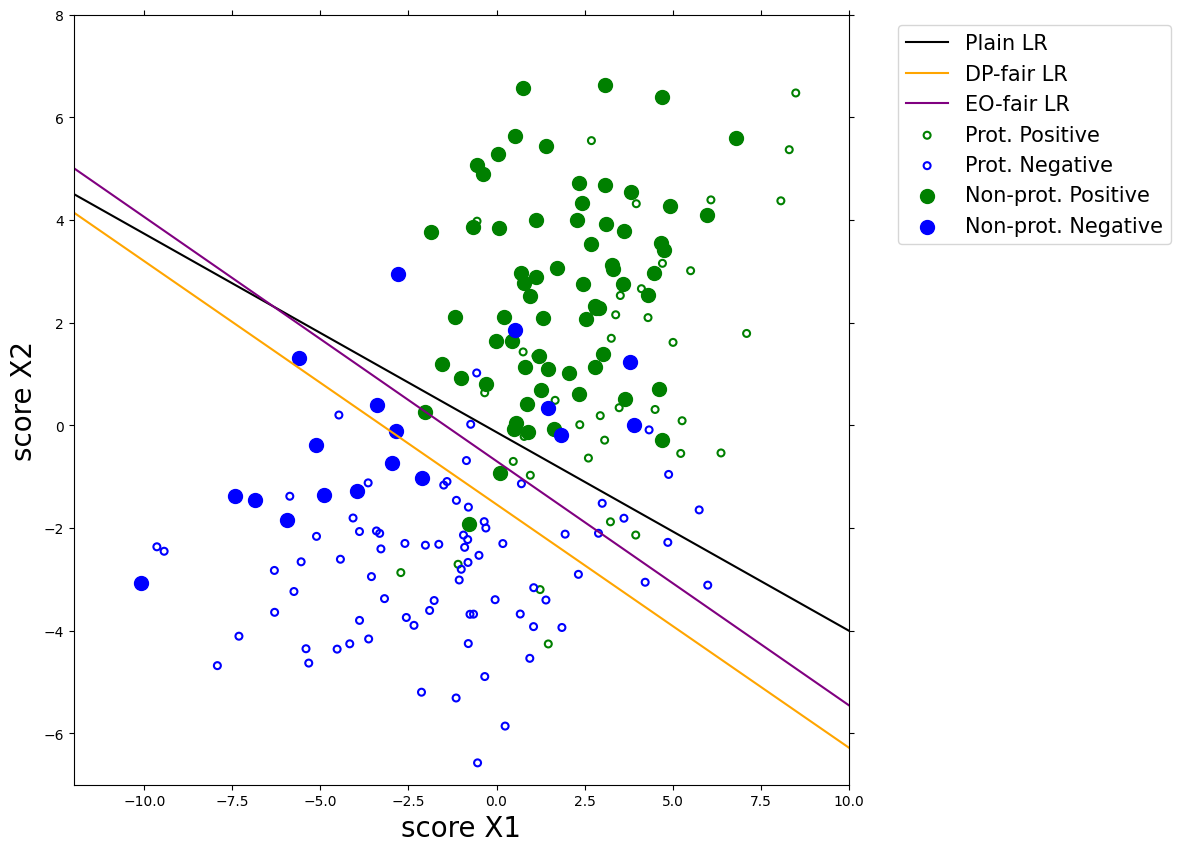

In [ ]:
# @title
# plot
fig,ax = plt.subplots(1,1, figsize=(10,10))
ax.plot(*get_lr_boundary(my_model_plain.theta.detach().numpy()[0:2], my_model_plain.bias.detach().numpy()[0], -15,10), color="black", label= "Plain LR")
ax.plot(*get_lr_boundary(my_model_dp.theta.detach().numpy()[0:2], my_model_dp.bias.detach().numpy()[0], -15,10), color="orange", label= "DP-fair LR")
ax.plot(*get_lr_boundary(my_model_eo.theta.detach().numpy()[0:2], my_model_eo.bias.detach().numpy()[0], -15,10), color="purple", label= "EO-fair LR")
plot_data(X_test[:,0:2],y_test,X_test[:,2],ax=ax)

## **Fairness-Accuracy Tradeoff**

The *fairness-accuracy-tradeoff* describes that in general, higher fairness yields lower accuracy, because a fairness constraint diverts the objective from accuracy alone to both accuracy and fairness. Let's try to see that with our implementation. While optimizing for accuracy subject to fairness constraints in the Lagrange implementation above, we adjust the weight that the fairness objective has during training with $\lambda$. While optimizing for accuracy subject to fairness constraints, the higher we choose $\lambda$ the more weight the fairness constraint has in the optimization. For a very high $\lambda$ this may result in a perfectly fair classifier but similarily a rather big loss in accuracy. Lets see if we try a range of values of $\lambda$, what kind of accuracy we achieve.

- For $\lambda = [0,0.1,1,10,100,1000, 10000]$ train a fair LR classifier with the fairness constraint `demographic_parity`.

- Use the provided function `plot_accuracy_fairness` to evaluate accuracy and fairness metrics for the different values of $\lambda$. What do you observe?

In [ ]:
# @title
from functools import partial
def plot_accuracy_fairness(model, X_test, y_test, pred, mask, verbose=False):
    err = test_error(pred,y_test)
    y_test = torch.tensor(y_test)
    dp_1,dp_0 = (demographic_parity(pred,mask),demographic_parity(pred,1-mask) )
    eo_1,eo_0 = (equal_opportunity(pred, y_test,mask),equal_opportunity(pred, y_test,1-mask))
    if verbose:
        print("Test error: ", err)
        print("Mean prediction: ", torch.Tensor.float(pred).mean().item())
        print("demographic_parity for unprotected: %.3f, for protected: %.3f, difference: %.3f" % (dp_1,dp_0, dp_1-dp_0))
        print("equal_opportunity for unprotected: %.3f, for protected: %.3f, difference: %.3f" % (dp_1,sp_0, dp_1-dp_0))
    return err, dp_1, dp_0, eo_1, eo_0

In [ ]:
# @title

torch.manual_seed(1)
lambdas = [0, 0.1,1,10,100,1000,10000]
err_list, dp_1_list, dp_0_list, eo_1_list, eo_0_list = [],[],[],[],[]
verbose = False # if True, it will print out results
for lambda_ in lambdas:
    X_train_tensor = torch.tensor(X_train).float()
    y_train_tensor = (torch.tensor(y_train).float()+1)/2
    X_test_tensor = torch.tensor(X_test).float()
    y_test_tensor = (torch.tensor(y_test).float()+1)/2

    my_model_dp = LogisticRegression(X_train_tensor.size(1))
    my_loss_function = partial(dp_loss, lambda_=lambda_)

    train(my_model_dp, my_loss_function, X_train_tensor, y_train_tensor, X_sens=X_train_tensor[:,2], epochs=2000, learning_rate=0.05, verbose=False)
    if verbose:
        print("Lambda: %.2f" % lambda_)
    err, dp_1, dp_0, eo_1, eo_0 = plot_accuracy_fairness(my_model_dp, X_test_tensor, y_test_tensor, my_model_dp.predict(X_test_tensor),test_data["sensitive"].to_numpy(), verbose)
    err_list.append(err)
    dp_1_list.append(dp_1)
    dp_0_list.append(dp_0)
    eo_1_list.append(eo_1)
    eo_0_list.append(eo_0)
    if verbose:
        print()


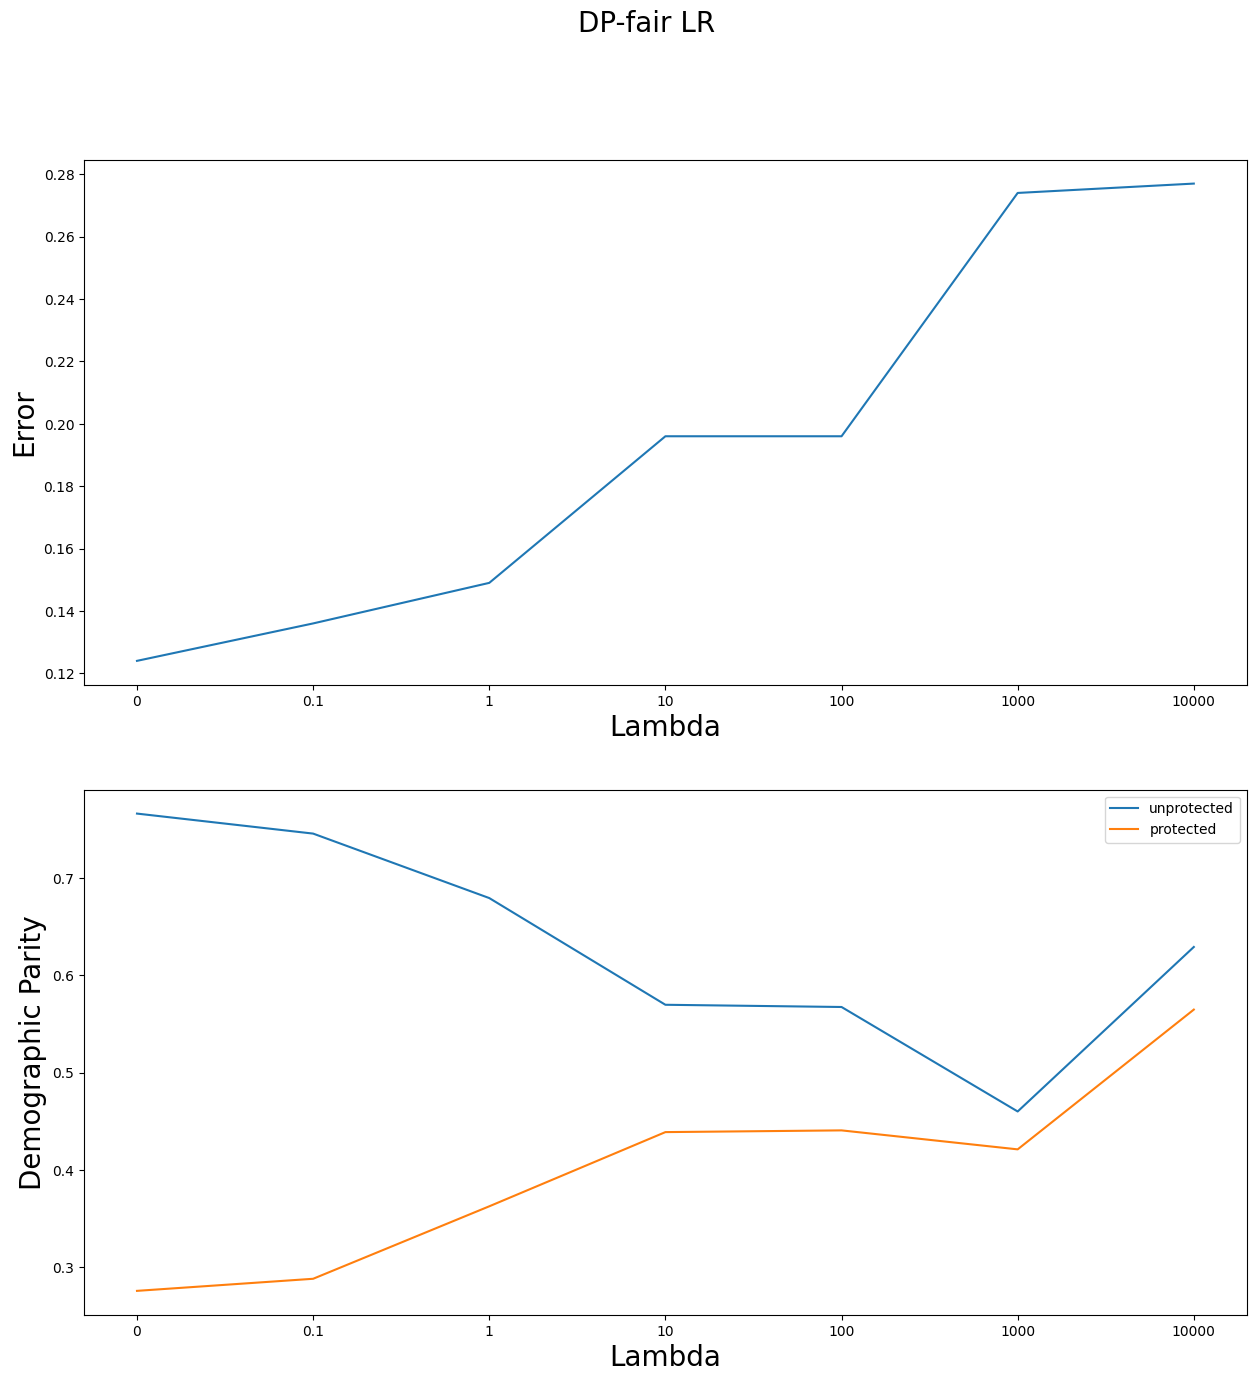

In [ ]:
fig, axes = plt.subplots(2,1, figsize=(15,15))
fig.suptitle("DP-fair LR" , fontsize=20)
axes[0].plot(err_list)
axes[0].set_xticks(range(len(lambdas)))
axes[0].set_xticklabels(lambdas)
axes[0].set_ylabel("Error", fontsize=20)
axes[0].set_xlabel("Lambda", fontsize=20)

axes[1].plot(dp_1_list, label="unprotected")
axes[1].plot(dp_0_list, label="protected")
axes[1].set_xticks(range(len(lambdas)))
axes[1].set_xticklabels(lambdas)
axes[1].set_ylabel("Demographic Parity", fontsize=20)
axes[1].set_xlabel("Lambda", fontsize=20)
axes[1].legend()



- For $\lambda = [0.01, 0.1, 0, 1, 10, 100, 1000]$ train a fair LR classifier with the fairness constraint `equal_opportunity`. Use the provided function `plot_accuracy_fairness` to evaluate accuracy and fairness metrics for the different values of $\lambda$. What do you observe?

In [ ]:
torch.manual_seed(0)
lambdas = [0,1,10,100,1000, 2000, 4000, 5000]
err_list, dp_1_list, dp_0_list, eo_1_list, eo_0_list = [],[],[],[],[]
verbose = False # if true, it will print out results
for lambda_ in lambdas:
    X_train_tensor = torch.tensor(X_train).float()
    y_train_tensor = (torch.tensor(y_train).float()+1)/2
    X_test_tensor = torch.tensor(X_test).float()
    y_test_tensor = (torch.tensor(y_test).float()+1)/2

    my_model_eo = LogisticRegression(X_train_tensor.size(1))
    my_loss_function = partial(eo_loss, lambda_=lambda_)

    train(my_model_eo, my_loss_function, X_train_tensor, y_train_tensor, X_sens=X_train_tensor[:,2], epochs=2000, learning_rate=0.05, verbose=False)
    if verbose:
        print("Lambda: %.2f" % lambda_)
    err, dp_1, dp_0, eo_1, eo_0 = plot_accuracy_fairness(my_model_eo, X_test_tensor, y_test_tensor, my_model_eo.predict(X_test_tensor),test_data["sensitive"].to_numpy(), verbose)
    err_list.append(err)
    dp_1_list.append(dp_1)
    dp_0_list.append(dp_0)
    eo_1_list.append(eo_1)
    eo_0_list.append(eo_0)
    if verbose:
        print()

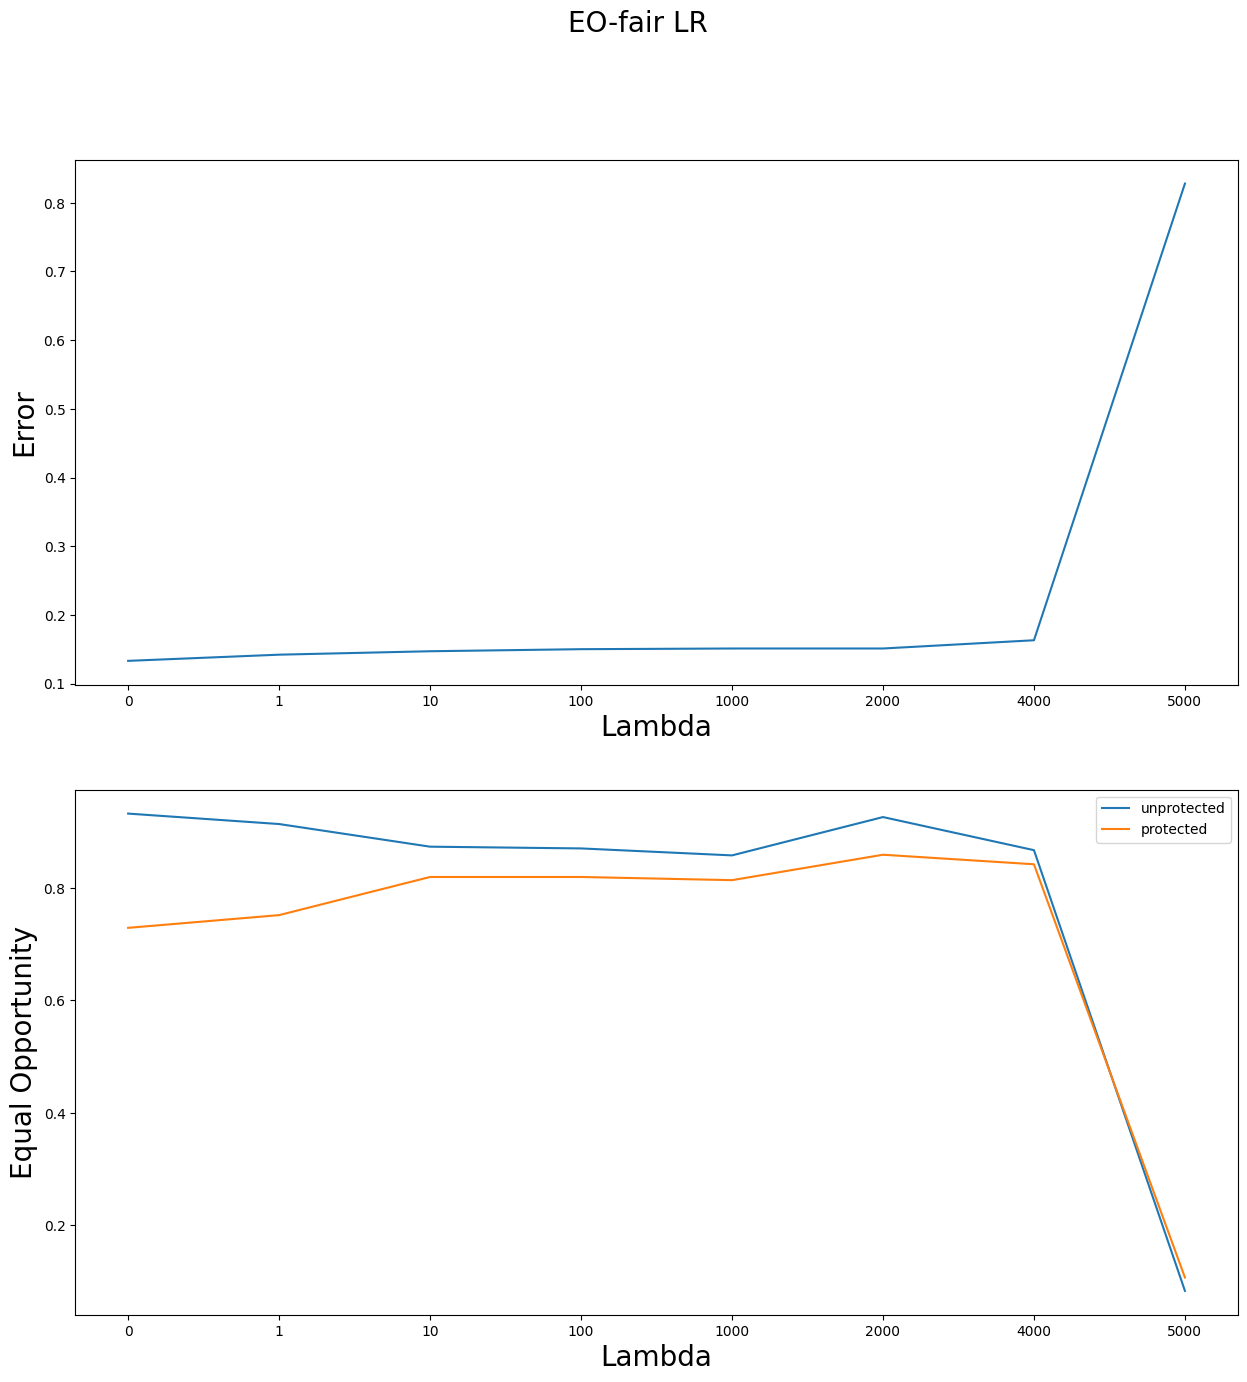

In [ ]:
fig, axes = plt.subplots(2,1, figsize=(15,15))
fig.suptitle("EO-fair LR" , fontsize=20)
axes[0].plot(err_list)
axes[0].set_xticks(range(len(lambdas)))
axes[0].set_xticklabels(lambdas)
axes[0].set_ylabel("Error", fontsize=20)
axes[0].set_xlabel("Lambda", fontsize=20)

axes[1].plot(eo_1_list, label="unprotected")
axes[1].plot(eo_0_list, label="protected")
axes[1].set_xticks(range(len(lambdas)))
axes[1].set_xticklabels(lambdas)
axes[1].set_ylabel("Equal Opportunity", fontsize=20)
axes[1].set_xlabel("Lambda", fontsize=20)
axes[1].legend()

# <font color='purple'>`Take Home`</font>
So far we have been using synthetic data as it allowed us to plot data and decision boundaries to get an intuition of what classification under different fairness notions can look like. Fairness plays an important role the moment we use an algorithm in the real world. Therefore, for your take home assignment, try to explore fairness using the COMPASS dataset.


## **Compas Data**
In 2016 ProPublica, an independent, nonprofit organization of investigative journalists, reported that an algorithm, which was used in the US legal system to predict a criminal defendant’s likelihood to re-offend, was racially biased. The algorithm referred to as COMPAS, which stands for Correctional Offender Management Profiling for Alternative Sanctions, is offered by the vendor Northpointe, Inc. ProPublica showed that black defendants were far more likely than white defendants to be incorrectly predicted to be at a higher risk of recidivism, while white defendants were more likely than black defendants to be incorrectly predicted to be at low risk (see [article](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing), [methodology](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm) of analysis).

The authors published the so-called [COMPAS Dataset](https://github.com/propublica/compas-analysis/).  This dataset is known in the fairness research community and a widely used to test the fairness of algorithms. We chose the dataset because of its extensive analysis available. The dataset contains the the criminal history, jail and prison time, demographics and COMPAS risk scores for defendants from Broward County, Florida, from 2013 and 2014. The dataset originally contains 7214. We load the dataset via the python class `load_compas_data.py` that we have also uploaded. It also carries out pre-processing for us. This reduces the dataset to 5278 samples with the following variables:

- All features $X$: age `age_cat`, race`race`, sex `sex`, number of prior convictions `priors_count`, severity of charge `c_charge_degree`
- Sensitive feature $S$: race `race` (`1` if African-American (protected), `-1` if Caucasian (unprotected))
- Target label $y$: accused of a crime within two years `two_year_recid` (`1`, if yes, `0` otherwise)


- Take a look at the analysis of the dataset [here](https://github.com/propublica/compas-analysis/blob/master/Compas%20Analysis.ipynb). What do you take away from this analysis?

-  Follow the same steps as in ( In-Processing): Train the plain, DP-fair, EO-fair classifier and evaluate their performance on the Compas dataset. What do you observe?

# Further Reading

Ethical machine learning, especially fairness in machine learning, has enjoyed increasing attention in the last years. Here is a non-exhaustive list of links for exploration, if you are interested in more information:


- **Less-technical:**

  * Orwat (2019): Risks of Discrimination through the Use of Algorithms, published by the German Federal Anti-Discrimination Agency. Available in [German](https://www.antidiskriminierungsstelle.de/SharedDocs/Downloads/DE/publikationen/Expertisen/studie_diskriminierungsrisiken_durch_verwendung_von_algorithmen.pdf?__blob=publicationFile&v=6) and [English](https://www.antidiskriminierungsstelle.de/SharedDocs/Downloads/EN/publikationen/Studie_en_Diskriminierungsrisiken_durch_Verwendung_von_Algorithmen.pdf?__blob=publicationFile&v=4).

- **Technical:**

  * Bell et al. (2023):  The Possibility of Fairness: Revisiting the Impossibility Theorem in Practice [here](https://dl.acm.org/doi/10.1145/3593013.3594007)


  * Barocas et al. (2019): Fairness and Machine Learning, [here](https://fairmlbook.org/) - a comprehensive technical overview of basic fairness approaches and concepts. Contains also links to further tutorials and lecture material.


- **Advanced:**

  * Publications at ACM FAccT Conference [here](https://facctconference.org/) recent cross-disciplinary scientific advances in the research community concerned with fairness, accountability, and transparency in socio-technical systems.

# Conclusion


**Summary / Key Take Away:**  


- Generated synthetic data

    - Trained a plain LR classifier
    
    - Evaluated performance of LR classifier
    
    - Trained a fair classifier using the lagragian approach
        * **BCE loss + λ × fairness**
        
    - Evaluated fairness using demographic parity and equality of opportunity
    
    - Fairness - Accuracy tradeoffs
    
      
- Unaware classifer != Fair Classifier

- Impossible to satisfy all fairness constraints at the same time

**Reminder: While developing and deploying accurate ML models, do not forget to ensure fairness !**



For other practicals from the Deep Learning Indaba, please visit [here](https://github.com/deep-learning-indaba/indaba-pracs-2023).



# Feedback

Please provide feedback that we can use to improve our practicals in the future.



In [ ]:
# @title Generate Feedback Form. (Run Cell)
from IPython.display import HTML

HTML(
    """
<iframe
	src="https://forms.gle/Cg9aoa7czoZCYqxF7",
  width="80%"
	height="1200px" >
	Loading...
</iframe>
"""
)

<img src="https://baobab.deeplearningindaba.com/static/media/indaba-logo-dark.d5a6196d.png" width="50%" />